# Improved Heating Parameterization

In [1]:
import os
import random
import logging
import subprocess
import multiprocessing

import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import matplotlib.colors
import synthesizAR
from synthesizAR.model_ext import EbtelInterface

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


It has become apparent that a bit more thought needs to be put into how the heating is parameterized across an active region, particularly with regard to exploring low, intermediate, and high frequency nanoflares. Specifically, the delay (or average delay) needs to be scaled according to the cooling time for each loop.

The total energy input per strand is constrained by 

$$
E_s = \frac{(\epsilon B_s)^2}{8\pi}
$$

where $B_s$ is the average field strength along the strand $s$ and $\epsilon$ is a stressing parameter, typically in the range $\epsilon\approx0.1-0.3$. Thus, we want the sum of all indvidual events $i$ along a given strand $s$, to be constrained by,

$$
\sum_iE_{i,s} = E_s \\
\sum_iE_{i,s} = \frac{(\epsilon B_s)^2}{8\pi} \\
$$

To find the $\{E_i\}$, we can sample a power-law distribution with slope $\alpha(<0)$ and bounds $\delta_0$ and $\delta_1$. We want to draw samples from the distribution until we've met the above condition. We'll say that we can draw $M$ samples to satisfy this condtion. One way to do this is to constrain the total amount of energy in our distribution by iteratively adjusting $[\delta_0,\delta_1]$ until the condition on $\sum_iE_i$ is met.

Now the question is: **how to we find the delay times $t_{N,i}$?** We adopt the following physical picture: in the Parker nanoflare model, reconnection occurs on small spatial and temporal scales and leads to energy frequently being released into the plasma. This reconnection is the result of the continual stressing of the coronal field. The more (i.e. longer) the field is stressed, the more energy is built up in the field. Similarly, we can reverse this situation and think of the delay as a cool down period such that more energetic events require a longer unwinding or "de-stressing" period. Following this picture, the delay time between events on a single strand should be proportional to the amount energy in a given event,

$$
E_i \propto t_{N,i}^{\beta} \to E_i = At_{N,i}^{\beta}
$$

where we'll use $\beta=1$ for now and $A$ is a normalization constant. Since we already know $E_i$ (we chose them from a distribution), to find $t_{N,i}$, we just need to calculate $A$.Recall that the waiting times must satisfy the equation

$$
\sum_{i=1}^Mt_{N,i} + M\Delta t = t_{total}
$$

so substituting in $t_{N,i}$,

$$
A\sum_{i=1}^ME_{i} + M\Delta t = t_{total} \\
AE_s = t_{total} - M\Delta t \\
AE_s = M\varepsilon\tau_{cool,s} \to A = M\varepsilon\tau_{cool,s}/E_s
$$

Thus, the delay time for event $i$ for strand $s$ can be written as,

$$
t_{N,i,s} = M\varepsilon\tau_{cool,s}\frac{E_i}{(\epsilon B_s)^2/8\pi}
$$

Notice that more highly stressed events will have a longer delay. However, we still need to make sure that the delay times are scaled proportionally to the cooling time $\tau_s$. Thus, we impose the constraint,

$$
\langle t_N\rangle/\tau_s = \varepsilon
$$
where $\langle t_N\rangle$ is the mean of the $t_{N,i}$ distribution and $\varepsilon$ sets the type of heating frequency we are looking at, e.g. $\varepsilon\sim0.1$ for high-frequency heating, $\varepsilon\sim1$ for intermediate frequency heating, $\varepsilon\sim10$ for low frequency heating. The bounds/slope of the original distribution of $\epsilon_i$ will need to be iteratively adjusted until this condition is met (within some tolerance).

We fix the number of events per strand based on both the cooling time $\tau_{cool,s}$ on that particular strand as well as our desired heating frequency which we parameterize in terms of $\varepsilon$ such that 

$$
\varepsilon\quad  
\begin{cases} 
      < 1 & \text{high frequency heating} \\
      \sim1 & \text{intermediate frequency heating} \\
      > 1 & \text{low frequency heating} 
\end{cases}
$$

with the idea being that the mean waiting time on a given strand $s$ is $\approx\varepsilon\tau_{cool,s}$. Thus, the number of events per strand $M_s$ can be fixed as,

$$
M_s = \frac{t_{total}}{\Delta t + \varepsilon\tau_{cool,s}}
$$

given a total simulation time $t_{total}$ and events of fixed duration $\Delta t$.  We'll choose $2\times10^4$ s for our total simulation time which is a reasonable choice and we'll assume an event duration of 200 s. For now, we'll choose a low-frequency case, i.e. $\langle t_N\rangle/\tau_{cool,s}<1$

## Build Field

Now, let's pull in a test AR and try some of these ideas.

In [2]:
crop_range = (u.Quantity([-425,-165],u.arcsec),u.Quantity([-375,-100],u.arcsec))
zshape = 100
zrange = u.Quantity([0,max(np.diff(crop_range))],u.arcsec)

In [3]:
field = synthesizAR.Skeleton(hmi_fits_file='/data/datadrive1/ar_forward_modeling/systematic_ar_study/obs_data/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits',
                             crop=crop_range,resample=u.Quantity([100,100],u.pixel))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [4]:
field.extrapolate_field(zshape=zshape,zrange=zrange)

True


yt : [INFO     ] 2017-08-17 12:34:20,784 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-08-17 12:34:20,785 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-08-17 12:34:20,787 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-08-17 12:34:20,788 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-08-17 12:34:20,789 Parameters: cosmological_simulation   = 0.0


In [5]:
field.extract_streamlines(500,loop_length_range=[1e9,2e10]*u.cm,close_threshold=0.05)

yt : [INFO     ] 2017-08-17 12:34:28,218 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 403.95it/s]
yt : [INFO     ] 2017-08-17 12:34:30,274 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 184/184 [00:00<00:00, 413.37it/s]
yt : [INFO     ] 2017-08-17 12:34:31,236 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 53/53 [00:00<00:00, 314.71it/s]
yt : [INFO     ] 2017-08-17 12:34:31,808 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 16/16 [00:00<00:00, 263.83it/s]
yt : [INFO     ] 2017-08-17 12:34:32,172 AMRKDTree rebuilt, Final Volume: 6.279785e+30
Streamlining: 100%|██████████| 4/4 [00:00<00:00, 151.79it/s]


In [6]:
field.make_loops()

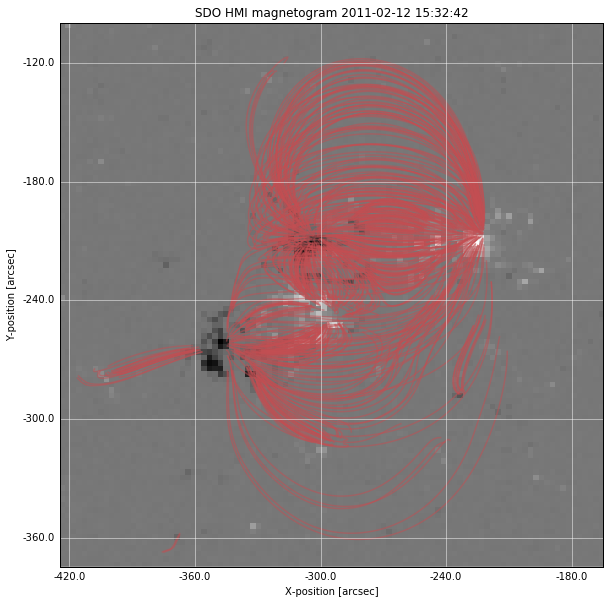

In [22]:
field.peek(color=sns.color_palette('deep')[2],alpha=0.5)

For convenience, make a list of loop lengths and average field strengths.

In [13]:
loop_lengths = u.Quantity([loop.full_length.value for loop in field.loops],field.loops[0].full_length.unit)
average_field_strengths = u.Quantity([np.average(loop.field_strength.value,
                                                 weights=np.gradient(loop.field_aligned_coordinate.value)) 
                                      for loop in field.loops],field.loops[0].field_strength.unit)

Now, look at the distribution of loop lengths and field strengths across the whole AR.

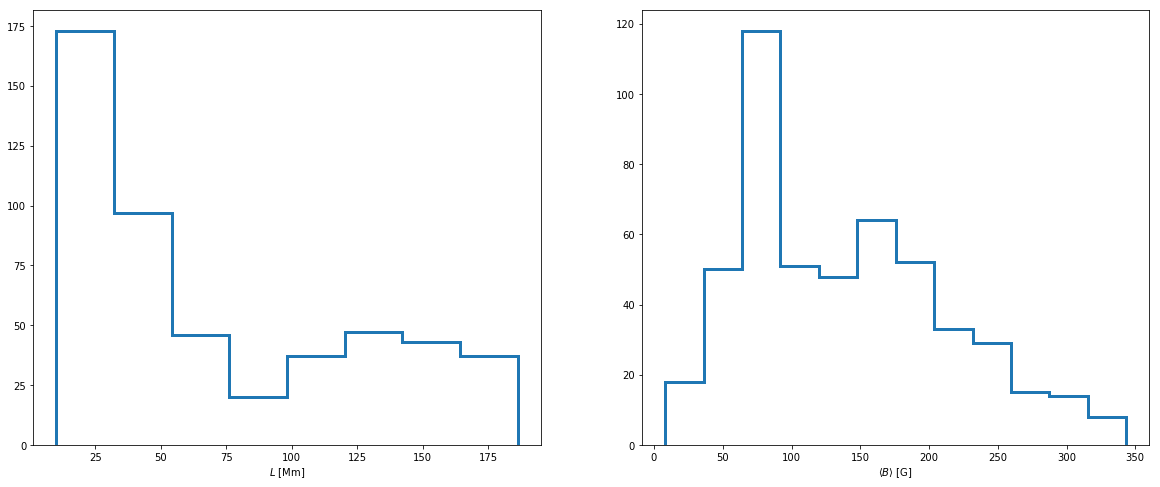

In [18]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.hist(loop_lengths.to(u.Mm).value,bins='fd',histtype='step',lw=3);
plt.xlabel(r'$L$ [Mm]')
plt.subplot(122)
plt.hist(average_field_strengths.value,bins='fd',histtype='step',lw=3);
plt.xlabel(r'$\langle B\rangle$ [G]')

What is the relation between $L$ and $\bar{B}$? We would expect it to be roughly inverse as longer loops tend to be rooted in weaker field and vice-versa.

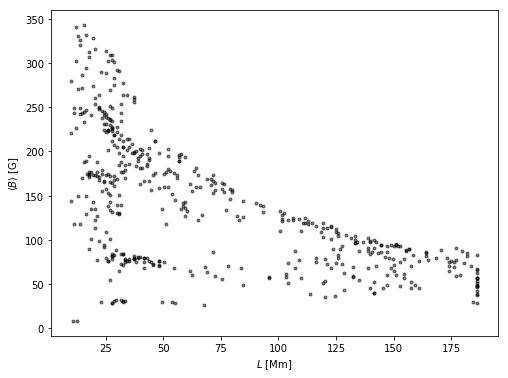

In [19]:
plt.figure(figsize=(8,6))
plt.plot(loop_lengths.to(u.Mm),average_field_strengths,'.k',alpha=0.5)
plt.xlabel(r'$L$ [Mm]')
plt.ylabel(r'$\langle B\rangle$ [G]')

## Estimating Cooling Times

Now, we want to calculate a typical cooling time which is primarily a function of the loop length. From Cargill (2014),

$$
\tau_{cool} = \frac{2-\alpha}{1-\alpha}3k_B\left(\frac{1}{\kappa_0^{4-2\alpha}\chi^7}\frac{L^{8-4\alpha}}{(n_0T_0)^{3+2\alpha}}\right)^{1/(11-2\alpha)}
$$

$L$ is given by the field extrapolation and the other constants are given by,
* $\alpha=-0.5$
* $\chi=6\times10^{-20}$
* $\kappa_0 = 10^{-6}$
* $k_B$ Boltzmann constant

But we need a way to estimate $n_0T_0$, where $T_0$ is the temperature from which the plasma is cooling and $n_0=n(T=T_0)$.

Recall from our hydrodynamic equations that the peak in the temperature occurs when thermal conduction is balanced by the heating input such that,

$$
E_H \approx \left|\frac{dF_c}{dT}\right|
$$

Recall that $F_c = \kappa_0T^{5/2}dT/ds=2\kappa_0/7d(T^{7/2})/ds$. Thus we can approximate the gradient of the heat flux from base to apex as,

$$
\frac{dF_c}{ds} \approx \frac{F_c(T_a) - F_c(T_b)}{L} \approx \frac{F_c(T_a)}{L} = \frac{2\kappa_0}{7L^2}T_a^{7/2}
$$

where $L$ is the loop half length. Recalling that $T_a/\bar{T}$, we can estimate the spatially-averaged peak temperature as,

$$
T_0 = 0.9\left(\frac{7L^2E_H}{2\kappa_0}\right)^{7/2}
$$

To calculate the density at $T_0=\max_tT$, we can use the energy and density equations from the EBTEL model. From the expression for $dp/dt$, noting that $p=2k_BnT$ and that $dT/dt$ at $T_0$, we can write,

$$
\frac{2k_B}{\gamma-1}T_0\frac{dn}{dt} = E_H - c_1n_0^2\chi T_0^{\alpha}
$$

and from the density equation,

$$
\frac{dn}{dt} = -\frac{c_2(\gamma - 1)}{c_32k_BT_0L\gamma}(F_c(T_0) + c_1n_0^2\chi T_0^{\alpha}L)
$$

Combining the two expressions, we get,

$$
-\frac{c_2}{c_3\gamma}\left(\frac{F_c(T_0)}{L} + c_1n_0^2\chi T_0^{\alpha}\right) = E_H - c_1n_0^2\chi T_0^{\alpha} \\
\frac{c_2}{c_3\gamma}\frac{F_c(T_0)}{L}  = -E_H + c_1n_0^2\chi T_0^{\alpha} - \frac{c_2}{c_3\gamma}c_1n_0^2\chi T_0^{\alpha} \\ 
E_H + \frac{c_2}{c_3\gamma}\frac{F_c(T_0)}{L} =  c_1n_0^2\chi T_0^{\alpha}\left(1 - \frac{c_2}{c_3\gamma}\right)
$$

and solving for $n_0$,

$$
n_0 = \sqrt{\frac{E_H + \frac{c_2}{c_3\gamma}\frac{F_c(T_0)}{L}}{c_1\chi T_0^{\alpha}\left(1 - \frac{c_2}{c_3\gamma}\right)}}
$$

where the heat flux is evaluated as

$$
F_c(T_0) = -\frac{2\kappa_0}{7L}\left(\frac{T_0}{c_2}\right)^{7/2}
$$

In [179]:
def calculate_n0_T0(half_lengths,avg_heating_rate):
    alpha = -0.5
    chi = 6e-20*(u.erg*(u.cm**3)/u.s*u.K**(0.5))
    kappa_0 = 1e-6*(u.erg/u.cm/u.s*(u.K**(-7/2)))
    c1,c2,c3 = 2.0,0.9,0.6
    gamma = 5./3.
    #T0 = (avg_heating_rate*(half_lengths**2)/kappa_0)**(2./7.)
    #T0 = ((avg_heating_rate*7.*(c2**2.5)*c3*(half_lengths**2)*gamma)/(2.*kappa_0))**(2./7.)
    T0 = c2*(7.*half_lengths**2*avg_heating_rate/2./kappa_0)**(2./7.)
    top_term = avg_heating_rate - 2.*kappa_0*(T0**(3.5))/(7.*(c2**2.5)*c3*(half_lengths**2)*gamma)
    bottom_term = c1*chi*(T0**alpha)*(1. - c2/c3/gamma)
    n0 = np.sqrt(top_term/bottom_term)
    return n0,T0

In [180]:
def cooling_time(loop_lengths,field_strengths,total_time):
    loop_half_lengths = loop_lengths/2.
    alpha = -0.5
    chi = 6e-20*(u.erg*(u.cm**3)/u.s*u.K**(0.5))
    kappa_0 = 1e-6*(u.erg/u.cm/u.s*(u.K**(-7/2)))
    epsilon = 0.1
    E_h_avg = ((epsilon*field_strengths.value)**2)/(8.*np.pi*total_time)*u.erg/(u.cm**3)/u.s
    # From RTV scaling laws
    #c1_const = 5.09e4*u.cm**(4/3)/u.s/(u.erg**(1/6))
    #n0T0 = (E_h_avg*(loop_half_lengths)**(5/6)/c1_const)**(6/7)/(2.*const.k_B.cgs)
    #n0T0 = (1e9*u.cm**(-3))*(1e7*u.K)
    #T0 = 6e6*u.K
    n0,T0 = calculate_n0_T0(loop_half_lengths,E_h_avg)
    n0T0 = n0*T0
    # Cargill cooling expression
    term1 = (2. - alpha)/(1. - alpha)
    term2 = (kappa_0**(4. - 2.*alpha))*(chi**7)
    term3 = ((loop_half_lengths)**(8. - 4.*alpha))/(n0T0**(3+2.*alpha))
    tau_cool = term1*3.*const.k_B.cgs*(1/term2*term3)**(1/(11. - 2.*alpha))
    return tau_cool


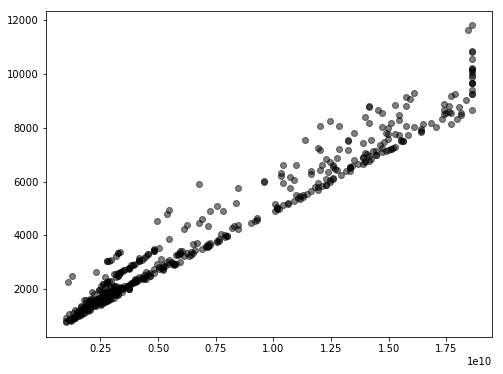

In [77]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
tau_cool = cooling_time(loop_lengths,average_field_strengths,1e2)
plt.plot(loop_lengths,tau_cool,'ok',alpha=0.5)

Our prediction gives a roughly linear relationship between cooling time and loop length as it should. But how does the predicted cooling time compare with actual cooling times?

Let's load in the cooling loops that we simulated previously and compare our estimates of the cooling times to actual cooling times computed between the peak temperature and the equilibrium temperature.

In [163]:
cool_field = synthesizAR.Skeleton.restore('/data/datadrive2/systematic_ar_study/noaa1158_cooling/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-08-17 18:53:47,332 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-08-17 18:53:47,332 Parameters: domain_dimensions         = [95 96 96]
yt : [INFO     ] 2017-08-17 18:53:47,333 Parameters: domain_left_edge          = [ -2.96081016e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-08-17 18:53:47,335 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   1.92016200e+10]
yt : [INFO     ] 2017-08-17 18:53:47,335 Parameters: cosmological_simulation   = 0.0


In [164]:
def real_cooling_time(loops):
    cooling_times = np.empty(len(loops))
    for i,loop in enumerate(loops):
        i_tmax = np.argmax(loop.electron_temperature[:,0])
        i_cool = np.where(loop.electron_temperature[:,0].value<=loop.electron_temperature[0,0].value)[0]
        i_cool = [ic for ic in i_cool if ic > i_tmax]
        if len(i_cool) > 0:
            i_cool = i_cool[0]
        else:
            i_cool = -1
        cooling_times[i] = loop.time[i_cool].value - loop.time[i_tmax].value
            
    return cooling_times

In [165]:
tau_cool_true = real_cooling_time(cool_field.loops)

In [166]:
loop_lengths_cooling = u.Quantity([loop.full_length.value for loop in cool_field.loops],field.loops[0].full_length.unit)
average_field_strengths_cooling = u.Quantity([np.average(loop.field_strength.value,
                                                 weights=np.gradient(loop.field_aligned_coordinate.value)) 
                                              for loop in cool_field.loops],field.loops[0].field_strength.unit)

In [189]:
tau_cool_estimated = cooling_time(loop_lengths_cooling,average_field_strengths_cooling,1e2)

(500, 10000.0)

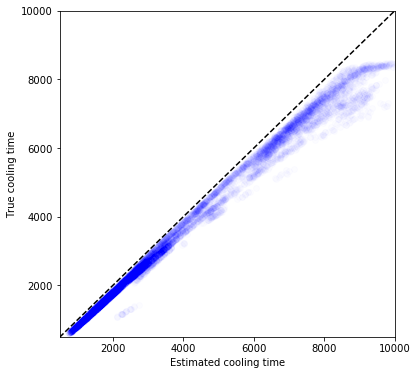

In [190]:
plt.figure(figsize=(6,6))
plt.plot(tau_cool_estimated,tau_cool_true,'ob',alpha=0.01)
plt.plot(np.linspace(0,2e4,10),np.linspace(0,2e4,10),'--k')
plt.xlabel(r'Estimated cooling time')
plt.ylabel(r'True cooling time')
plt.ylim([500,1e4])
plt.xlim([500,1e4])

We see that we do a decent job of estimating the cooling times though we seem to systematically overestimate them. Note that we only have real cool times out to 10000 s because our cooling simulation only lasted this long.

## Distribution of Heating Events
Create a distribution of heating events on the interval $[\delta_0\langle E\rangle,\delta_1\langle E\rangle]$, where $\langle E\rangle$ is average energy available per strand over the whole AR.

In [81]:
def power_law(a0,a1,alpha,x):
    return ((a1**(alpha + 1.) - a0**(alpha + 1.))*x + a0**(alpha + 1.))**(1./(alpha + 1.))

In [83]:
epsilon = 0.1
delta_eps0 = 0.5
delta_eps1 = 5
alphas = [-1.5,-2,-2.5,-5,-10]

In [84]:
strand_energies = ((epsilon*average_field_strengths.value)**2)/8/np.pi
average_available_energy = strand_energies.mean()

We'll fix the bounds of the distribution using the minimum and maximum strand energies. We want a lower bound significantly below the lowest strand energy so that the choices for those strands rooted in weaker field will not be limited to one huge event. Similarly, we want to expand to the largest possible energy as well to allow for really big events if a strand has enough energy available.

In [85]:
E0 = delta_eps0*strand_energies.min()#delta_eps0*average_available_energy
E1 = delta_eps1*strand_energies.max()#delta_eps1*average_available_energy

We want to use only the slope of our event energies to control the heating frequency.

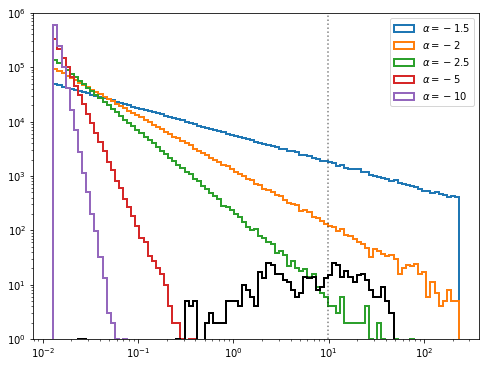

In [86]:
plt.figure(figsize=(8,6))
for alpha in alphas:
    p = power_law(E0,E1,alpha,np.random.rand(int(1e6)))
    plt.hist(p,
             bins=np.logspace(np.log10(E0),np.log10(E1),100),
             histtype='step',lw=2,label=r'$\alpha={}$'.format(alpha));
plt.hist(strand_energies,
         bins=np.logspace(np.log10(E0),np.log10(E1),100),
         color='k',lw=2,histtype='step')
plt.axvline(x=average_available_energy,color='k',ls=':',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
#plt.xlim([0.9*delta_eps0*epsilon,1.1*epsilon])
plt.ylim([1,len(p)])
plt.legend()

Let's choose a slope of $\alpha=-2$.

In [87]:
energy_distribution = power_law(E0,E1,-2,np.random.rand(int(1e7)))

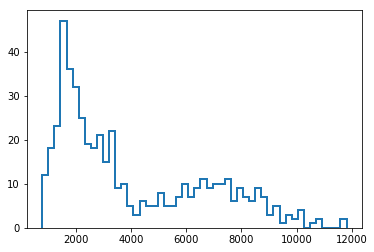

In [88]:
plt.hist(tau_cool,histtype='step',lw=2,bins=50);

We fix the number of events per strand based on both the cooling time $\tau_{cool,s}$ on that particular strand as well as our desired heating frequency which we parameterize in terms of $\varepsilon$. The number of events per strand $M_s$ can be fixed as,

$$
M_s = \frac{t_{total}}{\Delta t + \varepsilon\tau_{cool,s}}
$$

given a total simulation time $t_{total}$ and events of fixed duration $\Delta t$.

In [89]:
frequency_param = 0.1
total_time = 2e4
duration = 200.0

In [91]:
number_of_events = np.floor(total_time/(duration + frequency_param*tau_cool.value))
number_of_events = number_of_events.astype(int)

How does the number of events vary with loop length for a few different frequency parameters?

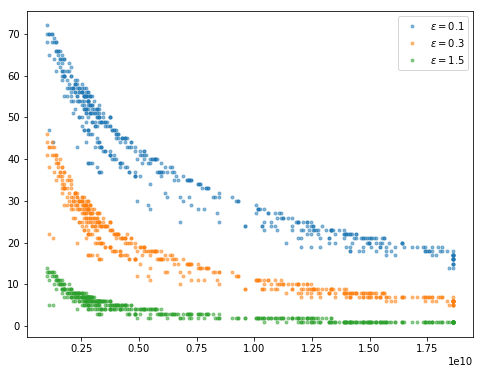

In [92]:
plt.figure(figsize=(8,6))
for fp in [0.1,0.3,1.5]:
    plt.plot(loop_lengths,
             (np.floor(total_time/(duration + fp*tau_cool.value))).astype(int),
             '.',alpha=0.5,label=r'$\varepsilon={}$'.format(fp))
plt.legend()

The next constraint we need to satisfy is the total amount of energy in the distribution. We want to make sure that 
the amount of energy released into the loop is equal to the non-potential component of the field and thus independent of the selected heating frequency. 

In other words, for a strand $s$ and any value $\varepsilon$, we need to satisfy the constraint,

$$
\sum_{i=1}^{M_s} E_{i,s} = E_s = \frac{(\epsilon B_s)^2}{8\pi}
$$

Let's try naively sampling the distribution shown above (with fixed bounds,$\alpha=-2$) where the bounds are determined by the properties of the AR as a whole. 

In [93]:
input_energy = np.array([power_law(E0,E1,-2,np.random.rand(m)).sum() for m in number_of_events])

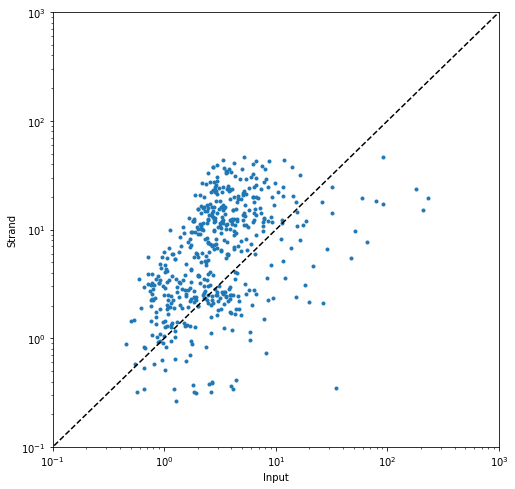

In [97]:
plt.figure(figsize=(8,8))
plt.plot(input_energy,strand_energies,'.')
x = np.logspace(-3,3,1000)
plt.plot(x,x,'--k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-1,1e3])
plt.ylim([1e-1,1e3])
plt.xlabel('Input')
plt.ylabel('Strand')

We need to come up with a strategy for constraining the distribution based on the desired energy input.

In [98]:
def constrain_distribution(strand_energy, num_events, alpha, max_tries=2000, tol=1e-3, **kwargs):
        """
        Choose events from power-law distribution such that total desired energy input is conserved.
        """
        # initial guess of bounds
        a0 = 0.1*strand_energy/num_events
        delta_bounds = 100
        a1 = delta_bounds*a0
        # initialize parameters
        tries = 0
        err = 1.e+300
        best_err = err
        while tries < max_tries and err > tol:
            x = np.random.rand(num_events)
            h = power_law(a0, a1, alpha, x)
            pl_sum = np.sum(h)
            chi = strand_energy/pl_sum
            a0 = chi*a0
            a1 = delta_bounds*a0
            err = np.fabs(1.-1./chi)
            if err < best_err:
                best = h
                best_err = err
            tries += 1

        #print("chi = {}, # of tries = {}, error = {}".format(chi, tries, err))

        if tries >= max_tries:
            print("Power-law constrainer reached max # of tries, using best guess with error = {}".format(best_err))

        return np.array(random.sample(list(best), len(best)))

In [99]:
input_energy_constrained = [constrain_distribution(se,m,-2,tol=3e-3) for se,m in zip(strand_energies,number_of_events)]

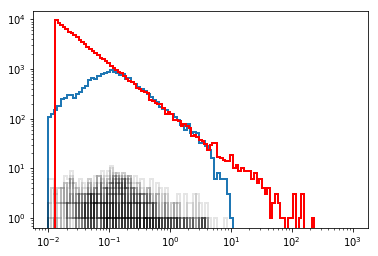

In [101]:
plt.hist(np.concatenate(input_energy_constrained),
         bins=np.logspace(-2,3,100),
         histtype='step',lw=2);
for d in input_energy_constrained[::10]:
    plt.hist(d,bins=np.logspace(-2,3,100),histtype='step',lw=2,alpha=0.1,color='k');
plt.hist(power_law(E0,E1,-2,np.random.rand(int(1e5))),
         bins=np.logspace(np.log10(E0),np.log10(E1),100),
         histtype='step',lw=2,label=r'$\alpha={}$'.format(alpha),color='r');
plt.xscale('log')
plt.yscale('log')

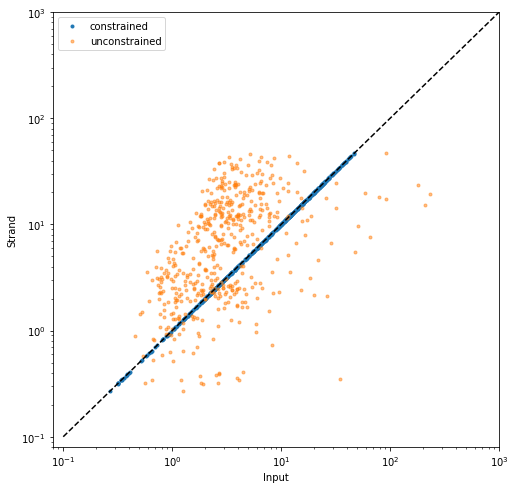

In [103]:
plt.figure(figsize=(8,8))
plt.plot(np.array([ie.sum() for ie in input_energy_constrained ]),strand_energies,'.',label='constrained')
plt.plot(input_energy,strand_energies,'.',alpha=0.5,label='unconstrained')
x = np.logspace(-1,3,1000)
plt.plot(x,x,'--k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([8e-2,1e3])
plt.ylim([8e-2,1e3])
plt.xlabel('Input')
plt.ylabel('Strand')
plt.legend()

And we can see that our iterative constrainer has done a good job of making sure that the total amount of sampled energy is equal to the amount made available by the stressed field.

Now, we can calculate the waiting or delay times using the expressions we gave above.

In [106]:
delay_times = [m*frequency_param*ct*ee/se 
                        for m,ct,ee,se in zip(number_of_events,
                                              tau_cool,
                                              input_energy_constrained,
                                              strand_energies)]

In [110]:
all_delay_ratios = np.concatenate([dt/ct for dt,ct in zip(delay_times,tau_cool)])

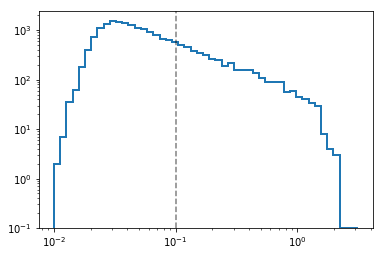

In [116]:
plt.hist(all_delay_ratios,bins=np.logspace(-2,0.5,50),log=True,histtype='step',lw=2);
plt.axvline(x=frequency_param,color='k',ls='--',alpha=0.5)
plt.xscale('log')

We see that our delay time to cooling time ratios fall about the input value of the frequency parameter $\varepsilon$